In [1]:
%matplotlib inline
import sys
sys.path.append('../../../stlcg_karen/src')
sys.path.append('../../expert_demo_ros/src/utils')
sys.path.append('../')
import stlcg
import matplotlib.pyplot as plt


from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from torch.utils.data import Dataset, DataLoader

import numpy as np
import os
import pickle
import torch
import pickle
import scipy.io as sio
import tensorflow as tf

from torch_interpolations.torch_interpolations.multilinear import RegularGridInterpolator
from torch.utils.tensorboard import SummaryWriter
from environment import *
from src.learning import *

In [3]:
state_dim = 4
ctrl_dim = 2
lstm_dim = 32

a_min=-3
a_max=3
delta_min=-0.344
delta_max=0.344

vf = HJIValueFunction.apply
dropout=0.0

In [106]:

params = {  "covers": [Box([0., 6.],[4, 8.]), Box([6., 2.],[10.0, 4.0])],
            "obstacles": [Circle([7., 7.], 2.0)],
            "initial": Box([-1., -1.],[1., 1.]),
            "final": Box([9.0, 9.0],[11.0, 11.0])
       }

cov_env = CoverageEnv(params)
draw_params = {"initial": {"color": "lightskyblue", "fill": True, "alpha": 0.5}, "final": {"color": "coral", "fill": True, "alpha": 0.5}, "covers": {"color": "black", "fill": False}, "obs": {"color": "red", "fill": True, "alpha": 0.5} }


In [138]:
x_train_, u_train_, stats = prepare_data("../../hji/data/expert_traj_train.npy")
x_eval_, u_eval_, _ = prepare_data("../../hji/data/expert_traj_eval.npy")

ic_train_ = torch.Tensor(InitialConditionDataset(2048, vf)).float()
ic_eval_ = torch.tensor(InitialConditionDataset(128, vf)).float()


# standardized data
x_train = standardize_data(x_train_, stats[0][:,:,:4], stats[1][:,:,:4])
u_train = standardize_data(u_train_, stats[0][:,:,4:], stats[1][:,:,4:])

x_eval = standardize_data(x_eval_, stats[0][:,:,:4], stats[1][:,:,:4])
u_eval = standardize_data(u_eval_, stats[0][:,:,4:], stats[1][:,:,4:])

ic_train = standardize_data(ic_train_, stats[0][:,:,:4], stats[1][:,:,:4])
ic_eval = standardize_data(ic_eval_, stats[0][:,:,:4], stats[1][:,:,:4])


ic_trainloader = torch.utils.data.DataLoader(ic_train, batch_size=32, shuffle=True)

In [139]:
model = STLPolicy(kinematic_bicycle, state_dim, ctrl_dim, lstm_dim, stats, cov_env, vf, dropout)
checkpoint = torch.load("../models/policy_run=0_lstm_dim=32_dropout=0.00_teacher_training=-1.0_weight_ctrl=0.7_weight_recon=1.0_weight_hji=0.0_weight_stl=0.1_device=cpu")
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

mu_x, sigma_x = model.stats[0][:,:,:4], model.stats[1][:,:,:4]
mu_u, sigma_u = model.stats[0][:,:,4:], model.stats[1][:,:,4:]

In [140]:
ic_eval.shape, ic_train.shape

(torch.Size([128, 1, 4]), torch.Size([2048, 1, 4]))

In [149]:
eval_loader = torch.utils.data.DataLoader(ic_eval, batch_size=ic_eval.shape[0], shuffle=False)
train_loader = torch.utils.data.DataLoader(ic_train, batch_size=32, shuffle=True)

device='cpu'

In [150]:
T = 30
model.eval()
for (batch_idx, ic_) in enumerate(train_loader):
    ic = ic_.permute([1,0,2]).to(device).float()
    o, u, x_pred = model(x_eval)
    x_future, u_future = model.propagate_n(T, ic)
    complete_traj = model.join_partial_future_signal(ic, x_future)

    
    traj_np = unstandardize_data(complete_traj, mu_x, sigma_x).cpu().detach().numpy()
    x_future, u_future = model.propagate_n(T, x_eval[:1,:,:])
    p = model.join_partial_future_signal(x_eval[:1,:,:], x_future)
    p = unstandardize_data(p, mu_x, sigma_x).squeeze().detach().cpu().numpy()

    x_pred = unstandardize_data(x_pred, mu_x, sigma_x)
    fig1 = plt.figure(figsize=(10,10))
    model.env.draw2D(kwargs=draw_params)
    plt.axis("equal")
    plt.plot(x_eval_.squeeze().cpu().numpy()[:,0], x_eval_.squeeze().cpu().numpy()[:,1], linewidth=4)
    plt.scatter(x_eval_.squeeze().cpu().numpy()[:,0], x_eval_.squeeze().cpu().numpy()[:,1], s=100)
    plt.plot(p[:,0], p[:,1], linewidth=4)
    plt.scatter(p[:,0], p[:,1], marker='^', s=100)
    plt.plot(x_pred.squeeze().cpu().detach().numpy()[:,0], x_pred.squeeze().cpu().detach().numpy()[:,1])
    plt.scatter(x_pred.squeeze().cpu().detach().numpy()[:,0], x_pred.squeeze().cpu().detach().numpy()[:,1], marker='*', s=100)
    for j in range(traj_np.shape[1]):
        plt.plot(traj_np[:,j,0], traj_np[:,j,1])
        plt.scatter(traj_np[:,j,0], traj_np[:,j,1])
    plt.xlim([-3, 12])
    plt.ylim([-3, 12])
    
    
    fig2 = plt.figure(figsize=(15,6))
    for k in [0,1]:
        plt.subplot(1,2,k+1)
        plt.plot(u_eval_.squeeze().cpu().detach().numpy()[:,k])
        plt.plot(unstandardize_data(u_future, mu_u, sigma_u).squeeze().cpu().detach().numpy()[:,k],'--')
        plt.grid()
        plt.xlim([0, 26])
        plt.ylim([-4,4])
    break

<Figure size 720x720 with 1 Axes>
<Figure size 1080x432 with 2 Axes>


In [151]:
traj_np.shape

(31, 32, 4)

In [157]:
T = 30
model.eval()
for (batch_idx, ic_) in enumerate(eval_loader):
    ic = ic_.permute([1,0,2]).to(device).float()
    o, u, x_pred = model(x_eval)
    x_future, u_future = model.propagate_n(T, ic)
    complete_traj = model.join_partial_future_signal(ic, x_future)

    
    traj_np = unstandardize_data(complete_traj, mu_x, sigma_x).cpu().detach().numpy()
    x_future, u_future = model.propagate_n(T, x_eval[:1,:,:])
    p = model.join_partial_future_signal(x_eval[:1,:,:], x_future)
    p = unstandardize_data(p, mu_x, sigma_x).squeeze().detach().cpu().numpy()

    x_pred = unstandardize_data(x_pred, mu_x, sigma_x)
    fig1 = plt.figure(figsize=(10,10))
    model.env.draw2D(kwargs=draw_params)
    plt.axis("equal")
    plt.plot(x_eval_.squeeze().cpu().numpy()[:,0], x_eval_.squeeze().cpu().numpy()[:,1], linewidth=4)
    plt.scatter(x_eval_.squeeze().cpu().numpy()[:,0], x_eval_.squeeze().cpu().numpy()[:,1], s=100)
    plt.plot(p[:,0], p[:,1], linewidth=4)
    plt.scatter(p[:,0], p[:,1], marker='^', s=100)
    plt.plot(x_pred.squeeze().cpu().detach().numpy()[:,0], x_pred.squeeze().cpu().detach().numpy()[:,1])
    plt.scatter(x_pred.squeeze().cpu().detach().numpy()[:,0], x_pred.squeeze().cpu().detach().numpy()[:,1], marker='*', s=100)
    for j in range(traj_np.shape[1]):
        plt.plot(traj_np[:,j,0], traj_np[:,j,1], alpha=0.4)
        plt.scatter(traj_np[:,j,0], traj_np[:,j,1], alpha=0.4)
    plt.xlim([-3, 12])
    plt.ylim([-3, 12])
    
    
    fig2 = plt.figure(figsize=(15,6))
    for k in [0,1]:
        plt.subplot(1,2,k+1)
        plt.plot(u_eval_.squeeze().cpu().detach().numpy()[:,k])
        plt.plot(unstandardize_data(u_future, mu_u, sigma_u).squeeze().cpu().detach().numpy()[:,k],'--')
        plt.grid()
        plt.xlim([0, 26])
        plt.ylim([-4,4])


<Figure size 720x720 with 1 Axes>
<Figure size 1080x432 with 2 Axes>


In [153]:
traj_np.shape

(31, 128, 4)

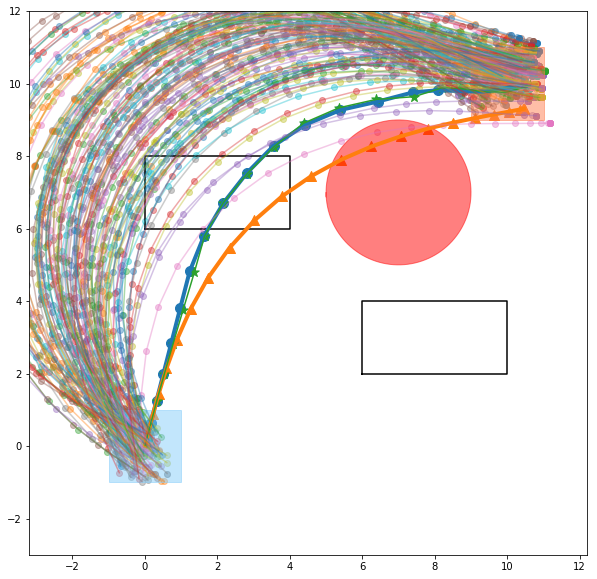

In [158]:
fig1

In [29]:
def plot_xy_from_tensor(x_train, fig=None):
    xy = x_train.squeeze().detach().numpy()[:,:2]
    if fig is None:
        fig = plt.figure(figsize=(10,8))
    plt.plot(xy[:,0], xy[:,1])
    plt.scatter(xy[:,0], xy[:,1])
    return fig

In [9]:

params = {  "covers": [Box([0., 6.],[4, 8.]), Box([6., 2.],[10.0, 4.0])],
            "obstacles": [Circle([7., 7.], 2.0)],
            "initial": Box([-1., -1.],[1., 1.]),
            "final": Box([9.0, 9.0],[11.0, 11.0])
       }

cov_env = CoverageEnv(params)
draw_params = {"initial": {"color": "lightskyblue", "fill": True, "alpha": 0.5}, "final": {"color": "coral", "fill": True, "alpha": 0.5}, "covers": {"color": "black", "fill": False}, "obs": {"color": "red", "fill": True, "alpha": 0.5} }


In [10]:
# prepare data and standardize

# original data
x_train_, u_train_, stats = prepare_data("../../hji/data/expert_traj_train.npy")
x_eval_, u_eval_, _ = prepare_data("../../hji/data/expert_traj_eval.npy")

ic_train_ = torch.Tensor(InitialConditionDataset(2048)).float()
ic_eval_ = torch.tensor(initial_conditions(128)).float()


# standardized data
x_train = standardize_data(x_train_, stats[0][:,:,:4], stats[1][:,:,:4])
u_train = standardize_data(u_train_, stats[0][:,:,4:], stats[1][:,:,4:])

x_eval = standardize_data(x_eval_, stats[0][:,:,:4], stats[1][:,:,:4])
u_eval = standardize_data(u_eval_, stats[0][:,:,4:], stats[1][:,:,4:])

ic_train = standardize_data(ic_train_, stats[0][:,:,:4], stats[1][:,:,:4])
ic_eval = standardize_data(ic_eval_, stats[0][:,:,:4], stats[1][:,:,:4])


ic_trainloader = torch.utils.data.DataLoader(ic_train, batch_size=32, shuffle=True)


TypeError: __init__() missing 1 required positional argument: 'vf'

In [12]:
x_train.shape

torch.Size([27, 1, 4])

In [13]:
ic_train.shape

torch.Size([2048, 1, 4])

In [14]:
u_eval.shape

torch.Size([27, 1, 2])

In [14]:
stl_traj = x_train.permute([1,0,2]).flip(1)
circle =  cov_env.obs[0]


def outside_circle_stl(signal, circle):
    d2 = stlcg.Expression('d2_to_center', (signal[:,:,:2] - torch.tensor(circle.center).unsqueeze(0).unsqueeze(0)).pow(2).sum(-1, keepdim=True))
    return stlcg.Always(subformula = d2 > circle.radius), d2
    

def in_box_stl(signal, box):
    x = stlcg.Expression('x', signal[:,:,:1])
    y = stlcg.Expression('y', signal[:,:,1:2])
    return ((x > box.lower[0]) & (y > box.lower[1])) & ((x < box.upper[0]) & (y < box.upper[1])), ((x, y),(x, y))

stl_traj = x_train.permute([1,0,2]).flip(1)
circle =  cov_env.obs[0]



obs_avoid, obs_avoid_input = outside_circle_stl(stl_traj, cov_env.obs[0])
in_box, in_box_input = in_box_stl(stl_traj, cov_env.final)
end_goal = stlcg.Eventually(subformula=stlcg.Always(subformula=in_box))


formula = obs_avoid & end_goal


def get_formula_input(signal):
    d2 = stlcg.Expression('d2_to_center', (signal[:,:,:2] - torch.tensor(circle.center).unsqueeze(0).unsqueeze(0)).pow(2).sum(-1, keepdim=True))
    x = stlcg.Expression('x', signal[:,:,:1])
    y = stlcg.Expression('y', signal[:,:,1:2])
    return (d2, ((x, y),(x, y)))

formula(get_formula_input(stl_traj))


tensor([[[-8.1606],
         [-8.1606],
         [-8.1606],
         [-8.1606],
         [-8.1606],
         [-8.1606],
         [-8.1606],
         [-8.1606],
         [-8.1606],
         [-8.1606],
         [-8.1606],
         [-8.1606],
         [-8.1606],
         [-8.1606],
         [-8.1606],
         [-8.1606],
         [-8.1606],
         [-8.1606],
         [-8.1606],
         [-8.1606],
         [-8.1606],
         [-8.1606],
         [-8.1606],
         [-8.1606],
         [-8.1606],
         [-8.1606],
         [-8.1606]]])

In [15]:
state_dim = 4
ctrl_dim = 2
hidden_dim = 32

a_min=-3
a_max=3
delta_min=-0.344
delta_max=0.344


policy = STLPolicy(kinematic_bicycle, state_dim, ctrl_dim, hidden_dim, stats)
optimizer = torch.optim.Adam(policy.parameters(), lr=0.001)


# testing functions
x_future, u_future = policy.propagate_n(10, x_train[:1,:,:])

policy.HJI_loss(x_future)
policy.STL_loss(x_future, formula, get_formula_input, scale=-1)

TypeError: __init__() missing 1 required positional argument: 'env'

In [9]:
xl, ul = policy.state_control_loss(x_train, x_train, u_train, teacher_training=0.1)
xl

tensor(0.1237, grad_fn=<MseLossBackward>)

In [10]:
writer = SummaryWriter()


In [11]:
T = x_train.shape[0]+4
weight_recon = 1.0
weight_ctrl = 0.7
weight_HJI = 0.1
weight_stl = 0.1
b = 50
c = 10
teacher_training = lambda ep: np.exp(ep/b - c) / (1 + np.exp(ep/b - c))


iteration = 0
epochs = 1000

PATH = "models/recon_%.1f_ctrl_%.1f_HJI_%.1f_STL_%.1f"%(weight_recon, weight_ctrl, weight_HJI, weight_stl)

for ep in range(epochs):
    for (i,ic_) in enumerate(ic_trainloader):
        ic = ic_.permute([1,0,2]).float()
        policy.train()
        optimizer.zero_grad()
        # reconstruct the expert policy
        loss_state, loss_ctrl = policy.state_control_loss(x_train, x_train, u_train, teacher_training=teacher_training(ep))
        loss_recon = loss_state + weight_ctrl * loss_ctrl
        
        # with new ICs, propagate the trajectories and keep them inside the reachable set
        x_future, u_future = policy.propagate_n(T, ic)
        complete_traj = policy.join_partial_future_signal(ic, x_future)
        loss_HJI = policy.HJI_loss(complete_traj)
        
        # stl loss
        loss_stl = policy.STL_loss(complete_traj, formula, get_formula_input, scale=-1)
        
        # total loss
        loss = weight_recon * loss_recon + weight_HJI * loss_HJI + weight_stl * loss_stl

        if torch.isnan(loss):
            print("Encountered NaN!")
            break
        else: 
            save_model(policy, optimizer, iteration, loss, PATH)


        writer.add_scalar('train/state', loss_state, iteration)
        writer.add_scalar('train/ctrl', loss_ctrl, iteration)
        writer.add_scalar('train/HJI', loss_HJI, iteration)
        writer.add_scalar('train/STL', loss_stl, iteration)
        writer.add_scalar('train/total', loss, iteration)
        
        if i % 20 == 0:
            traj_np = unstandardize_data(complete_traj, stats[0][:,:,:state_dim], stats[1][:,:,:state_dim]).detach().numpy()
            x_future, u_future = policy.propagate_n(T, x_train[:1,:,:])
            p = policy.join_partial_future_signal(x_train[:1,:,:], x_future)
            p = unstandardize_data(p, stats[0][:,:,:state_dim], stats[1][:,:,:state_dim]).squeeze().detach().numpy()

            fig = plt.figure(figsize=(10,10))
            cov_env.draw2D(kwargs=draw_params)
            plt.axis("equal")
            plt.plot(x_train_.squeeze().cpu().numpy()[:,0], x_train_.squeeze().cpu().numpy()[:,1])
            plt.scatter(x_train_.squeeze().cpu().numpy()[:,0], x_train_.squeeze().cpu().numpy()[:,1])

            for j in range(traj_np.shape[1]):
                plt.plot(traj_np[:,j,0], traj_np[:,j,1])
                plt.scatter(traj_np[:,j,0], traj_np[:,j,1])
                plt.plot(p[:,0], p[:,1])
                plt.scatter(p[:,0], p[:,1], marker='^', s=100)
            plt.xlim([-3, 12])
            plt.ylim([-3, 12])
            writer.add_figure('train/trajectory', fig, iteration)


            fig = plt.figure(figsize=(15,6))
            for k in [0,1]:
                plt.subplot(1,2,k+1)
                plt.plot(u_train_.squeeze().cpu().detach().numpy()[:,k])
                plt.plot(unstandardize_data(u_future, stats[0][:,:,4:], stats[1][:,:,4:]).squeeze().cpu().detach().numpy()[:,k],'--')
                plt.grid()
                plt.xlim([0, 26])
                plt.ylim([-4,4])
            writer.add_figure('train/controls', fig, iteration)


        loss.backward()
        optimizer.step()
        
        
        if i % 20 == 0:
            print("epoch %i\t loss: %.7f \t recon loss: %.3f \t HJI loss: %.3f \t STL loss: %.3f\n" %(i, loss, loss_recon, loss_HJI, loss_stl))
        iteration += 1
    
    # evaluation set
    policy.eval()
    loss_state, loss_ctrl = policy.state_control_loss(x_train, x_train, u_train, teacher_training=1.0)
    loss_recon = loss_state + weight_ctrl * loss_ctrl
    o, u = policy(x_eval)
    x_future, u_future = policy.propagate_n(T, ic_eval)
    complete_traj = policy.join_partial_future_signal(ic_eval, x_future)
    loss_HJI = policy.HJI_loss(complete_traj)
    loss_stl = policy.STL_loss(complete_traj, formula, get_formula_input, scale=-1)
    loss = weight_recon * loss_recon + weight_HJI * loss_HJI + weight_stl * loss_stl
    
    traj_np = unstandardize_data(complete_traj, stats[0][:,:,:state_dim], stats[1][:,:,:state_dim]).detach().numpy()
    x_future, u_future = policy.propagate_n(T, x_eval[:1,:,:])
    p = policy.join_partial_future_signal(x_eval[:1,:,:], x_future)
    p = unstandardize_data(p, stats[0][:,:,:state_dim], stats[1][:,:,:state_dim]).squeeze().detach().numpy()
    
    
    print("epoch: %i    Loss: %.3f"%(ep, loss))
    writer.add_scalar('eval/state', loss_state, ep)
    writer.add_scalar('eval/ctrl', loss_ctrl, ep)
    writer.add_scalar('eval/HJI', loss_HJI, ep)
    writer.add_scalar('eval/STL', loss_stl, iteration)
    writer.add_scalar('eval/total', loss, ep)
    
    fig = plt.figure(figsize=(10,10))
    cov_env.draw2D(kwargs=draw_params)
    plt.axis("equal")
    plt.plot(x_eval_.squeeze().cpu().numpy()[:,0], x_eval_.squeeze().cpu().numpy()[:,1])
    plt.scatter(x_eval_.squeeze().cpu().numpy()[:,0], x_eval_.squeeze().cpu().numpy()[:,1])
    
    for j in range(ic_eval.shape[1]):
        plt.plot(traj_np[:,j,0], traj_np[:,j,1])
        plt.scatter(traj_np[:,j,0], traj_np[:,j,1])
        plt.plot(p[:,0], p[:,1])
        plt.scatter(p[:,0], p[:,1], marker='^', s=100)
    plt.xlim([-3, 12])
    plt.ylim([-3, 12])
    writer.add_figure('eval/trajectory', fig, ep)
    
    
    fig = plt.figure(figsize=(15,6))
    for k in [0,1]:
        plt.subplot(1,2,k+1)
        plt.plot(u_eval_.squeeze().cpu().detach().numpy()[:,k])
        plt.plot(unstandardize_data(u_future, stats[0][:,:,4:], stats[1][:,:,4:]).squeeze().cpu().detach().numpy()[:,k],'--')
        plt.grid()
        plt.xlim([0, 26])
        plt.ylim([-4,4])
    writer.add_figure('eval/controls', fig, ep)


epoch 0	 loss: 7.8214588 	 recon loss: 1.338 	 HJI loss: 41.144 	 STL loss: 23.690

epoch 20	 loss: 3.0449200 	 recon loss: 1.652 	 HJI loss: 3.802 	 STL loss: 10.131

epoch 40	 loss: 3.0179520 	 recon loss: 1.892 	 HJI loss: 1.161 	 STL loss: 10.099

epoch 60	 loss: 2.8096039 	 recon loss: 1.735 	 HJI loss: 0.985 	 STL loss: 9.764

epoch: 0    Loss: 6.203
epoch 0	 loss: 3.0065026 	 recon loss: 1.687 	 HJI loss: 3.249 	 STL loss: 9.949

epoch 20	 loss: 2.5991201 	 recon loss: 1.433 	 HJI loss: 1.611 	 STL loss: 10.047

epoch 40	 loss: 2.4424057 	 recon loss: 1.230 	 HJI loss: 2.090 	 STL loss: 10.035

epoch 60	 loss: 2.3468678 	 recon loss: 1.066 	 HJI loss: 2.859 	 STL loss: 9.945

epoch: 1    Loss: 5.672
epoch 0	 loss: 2.3051648 	 recon loss: 1.039 	 HJI loss: 2.739 	 STL loss: 9.927

epoch 20	 loss: 2.2656121 	 recon loss: 0.941 	 HJI loss: 3.073 	 STL loss: 10.178

epoch 40	 loss: 2.0322804 	 recon loss: 0.867 	 HJI loss: 1.590 	 STL loss: 10.061

epoch 60	 loss: 1.8004973 	 recon 

epoch 20	 loss: 1.4310464 	 recon loss: 0.412 	 HJI loss: 0.548 	 STL loss: 9.642

epoch 40	 loss: 1.4635563 	 recon loss: 0.411 	 HJI loss: 0.847 	 STL loss: 9.678

epoch 60	 loss: 1.4382391 	 recon loss: 0.409 	 HJI loss: 0.648 	 STL loss: 9.641

epoch: 23    Loss: 2.599
epoch 0	 loss: 1.4530625 	 recon loss: 0.409 	 HJI loss: 0.808 	 STL loss: 9.630

epoch 20	 loss: 1.4914237 	 recon loss: 0.408 	 HJI loss: 1.249 	 STL loss: 9.589

epoch 40	 loss: 1.4554520 	 recon loss: 0.406 	 HJI loss: 0.880 	 STL loss: 9.609

epoch 60	 loss: 1.4791422 	 recon loss: 0.405 	 HJI loss: 1.134 	 STL loss: 9.608

epoch: 24    Loss: 3.898
epoch 0	 loss: 1.5839210 	 recon loss: 0.406 	 HJI loss: 2.016 	 STL loss: 9.767

epoch 20	 loss: 1.5293989 	 recon loss: 0.403 	 HJI loss: 1.593 	 STL loss: 9.671

epoch 40	 loss: 1.4030014 	 recon loss: 0.402 	 HJI loss: 0.357 	 STL loss: 9.653

epoch 60	 loss: 1.4678766 	 recon loss: 0.401 	 HJI loss: 0.952 	 STL loss: 9.718

epoch: 25    Loss: 3.788
epoch 0	 loss:

epoch 40	 loss: 1.2990822 	 recon loss: 0.247 	 HJI loss: 0.862 	 STL loss: 9.658

epoch 60	 loss: 1.2849449 	 recon loss: 0.244 	 HJI loss: 0.821 	 STL loss: 9.588

epoch: 46    Loss: 2.535
epoch 0	 loss: 1.3157613 	 recon loss: 0.244 	 HJI loss: 1.136 	 STL loss: 9.586

epoch 20	 loss: 1.2634487 	 recon loss: 0.242 	 HJI loss: 0.655 	 STL loss: 9.561

epoch 40	 loss: 1.3332227 	 recon loss: 0.238 	 HJI loss: 1.285 	 STL loss: 9.663

epoch 60	 loss: 1.2897838 	 recon loss: 0.237 	 HJI loss: 1.010 	 STL loss: 9.522

epoch: 47    Loss: 4.139
epoch 0	 loss: 1.2745246 	 recon loss: 0.236 	 HJI loss: 0.730 	 STL loss: 9.655

epoch 20	 loss: 1.2851986 	 recon loss: 0.233 	 HJI loss: 0.925 	 STL loss: 9.597

epoch 40	 loss: 1.3026974 	 recon loss: 0.231 	 HJI loss: 1.075 	 STL loss: 9.637

epoch 60	 loss: 1.3620987 	 recon loss: 0.229 	 HJI loss: 1.644 	 STL loss: 9.689

epoch: 48    Loss: 4.735
epoch 0	 loss: 1.2086422 	 recon loss: 0.228 	 HJI loss: 0.216 	 STL loss: 9.587

epoch 20	 loss:

epoch 40	 loss: 1.2930206 	 recon loss: 0.166 	 HJI loss: 1.617 	 STL loss: 9.658

epoch 60	 loss: 1.2076844 	 recon loss: 0.165 	 HJI loss: 0.857 	 STL loss: 9.574

epoch: 69    Loss: 9.118
epoch 0	 loss: 1.1987774 	 recon loss: 0.165 	 HJI loss: 0.695 	 STL loss: 9.647

epoch 20	 loss: 1.3278091 	 recon loss: 0.166 	 HJI loss: 1.715 	 STL loss: 9.905

epoch 40	 loss: 1.2478473 	 recon loss: 0.164 	 HJI loss: 1.208 	 STL loss: 9.628

epoch 60	 loss: 1.2985320 	 recon loss: 0.165 	 HJI loss: 1.645 	 STL loss: 9.691

epoch: 70    Loss: 8.151
epoch 0	 loss: 1.2315606 	 recon loss: 0.165 	 HJI loss: 0.982 	 STL loss: 9.685

epoch 20	 loss: 1.2155321 	 recon loss: 0.164 	 HJI loss: 0.881 	 STL loss: 9.630

epoch 40	 loss: 1.1994200 	 recon loss: 0.165 	 HJI loss: 0.710 	 STL loss: 9.636

epoch 60	 loss: 1.1758974 	 recon loss: 0.164 	 HJI loss: 0.553 	 STL loss: 9.563

epoch: 71    Loss: 8.493
epoch 0	 loss: 1.2191335 	 recon loss: 0.164 	 HJI loss: 0.897 	 STL loss: 9.657

epoch 20	 loss:

epoch 40	 loss: 1.2802663 	 recon loss: 0.160 	 HJI loss: 1.557 	 STL loss: 9.650

epoch 60	 loss: 1.1329386 	 recon loss: 0.160 	 HJI loss: 0.188 	 STL loss: 9.546

epoch: 92    Loss: 11.212
epoch 0	 loss: 1.2038584 	 recon loss: 0.160 	 HJI loss: 0.795 	 STL loss: 9.649

epoch 20	 loss: 1.1761169 	 recon loss: 0.159 	 HJI loss: 0.605 	 STL loss: 9.561

epoch 40	 loss: 1.2019268 	 recon loss: 0.161 	 HJI loss: 0.746 	 STL loss: 9.663

epoch 60	 loss: 1.2693083 	 recon loss: 0.160 	 HJI loss: 1.319 	 STL loss: 9.775

epoch: 93    Loss: 11.389
epoch 0	 loss: 1.1667340 	 recon loss: 0.160 	 HJI loss: 0.470 	 STL loss: 9.601

epoch 20	 loss: 1.2921433 	 recon loss: 0.160 	 HJI loss: 1.556 	 STL loss: 9.766

epoch 40	 loss: 1.1833047 	 recon loss: 0.159 	 HJI loss: 0.546 	 STL loss: 9.693

epoch 60	 loss: 1.2082021 	 recon loss: 0.160 	 HJI loss: 0.810 	 STL loss: 9.675

epoch: 94    Loss: 7.618
epoch 0	 loss: 1.2619481 	 recon loss: 0.160 	 HJI loss: 1.439 	 STL loss: 9.584

epoch 20	 los

epoch 40	 loss: 1.1833359 	 recon loss: 0.158 	 HJI loss: 0.648 	 STL loss: 9.609

epoch 60	 loss: 1.1855050 	 recon loss: 0.158 	 HJI loss: 0.607 	 STL loss: 9.668

epoch: 115    Loss: 9.407
epoch 0	 loss: 1.2014252 	 recon loss: 0.158 	 HJI loss: 0.777 	 STL loss: 9.654

epoch 20	 loss: 1.2261865 	 recon loss: 0.159 	 HJI loss: 1.034 	 STL loss: 9.642

epoch 40	 loss: 1.1853337 	 recon loss: 0.158 	 HJI loss: 0.585 	 STL loss: 9.685

epoch 60	 loss: 1.2006050 	 recon loss: 0.158 	 HJI loss: 0.790 	 STL loss: 9.635

epoch: 116    Loss: 10.099
epoch 0	 loss: 1.1734064 	 recon loss: 0.158 	 HJI loss: 0.528 	 STL loss: 9.623

epoch 20	 loss: 1.2541981 	 recon loss: 0.158 	 HJI loss: 1.191 	 STL loss: 9.770

epoch 40	 loss: 1.1733611 	 recon loss: 0.158 	 HJI loss: 0.586 	 STL loss: 9.570

epoch 60	 loss: 1.1637597 	 recon loss: 0.158 	 HJI loss: 0.525 	 STL loss: 9.535

epoch: 117    Loss: 11.088
epoch 0	 loss: 1.1938803 	 recon loss: 0.158 	 HJI loss: 0.731 	 STL loss: 9.632

epoch 20	 

epoch 40	 loss: 1.2122861 	 recon loss: 0.157 	 HJI loss: 0.939 	 STL loss: 9.614

epoch 60	 loss: 1.1936023 	 recon loss: 0.157 	 HJI loss: 0.819 	 STL loss: 9.548

epoch: 138    Loss: 12.084
epoch 0	 loss: 1.1816467 	 recon loss: 0.157 	 HJI loss: 0.680 	 STL loss: 9.570

epoch 20	 loss: 1.2073889 	 recon loss: 0.157 	 HJI loss: 0.837 	 STL loss: 9.666

epoch 40	 loss: 1.2787112 	 recon loss: 0.157 	 HJI loss: 1.517 	 STL loss: 9.700

epoch 60	 loss: 1.2344385 	 recon loss: 0.157 	 HJI loss: 1.018 	 STL loss: 9.758

epoch: 139    Loss: 12.309
epoch 0	 loss: 1.1649051 	 recon loss: 0.156 	 HJI loss: 0.564 	 STL loss: 9.520

epoch 20	 loss: 1.2392997 	 recon loss: 0.157 	 HJI loss: 1.194 	 STL loss: 9.633

epoch 40	 loss: 1.2472451 	 recon loss: 0.156 	 HJI loss: 1.175 	 STL loss: 9.735

epoch 60	 loss: 1.1564826 	 recon loss: 0.157 	 HJI loss: 0.448 	 STL loss: 9.548

epoch: 140    Loss: 11.889
epoch 0	 loss: 1.2004657 	 recon loss: 0.157 	 HJI loss: 0.861 	 STL loss: 9.575

epoch 20	

epoch 40	 loss: 1.1908747 	 recon loss: 0.157 	 HJI loss: 0.720 	 STL loss: 9.614

epoch 60	 loss: 1.2504455 	 recon loss: 0.159 	 HJI loss: 1.217 	 STL loss: 9.700

epoch: 161    Loss: 11.663
epoch 0	 loss: 1.1628771 	 recon loss: 0.159 	 HJI loss: 0.445 	 STL loss: 9.598

epoch 20	 loss: 1.1885484 	 recon loss: 0.156 	 HJI loss: 0.625 	 STL loss: 9.697

epoch 40	 loss: 1.2519772 	 recon loss: 0.160 	 HJI loss: 1.162 	 STL loss: 9.763

epoch 60	 loss: 1.2188691 	 recon loss: 0.157 	 HJI loss: 0.942 	 STL loss: 9.677

epoch: 162    Loss: 11.300
epoch 0	 loss: 1.2736963 	 recon loss: 0.157 	 HJI loss: 1.416 	 STL loss: 9.753

epoch 20	 loss: 1.2266796 	 recon loss: 0.157 	 HJI loss: 1.060 	 STL loss: 9.637

epoch 40	 loss: 1.1944221 	 recon loss: 0.158 	 HJI loss: 0.851 	 STL loss: 9.516

epoch 60	 loss: 1.1862266 	 recon loss: 0.157 	 HJI loss: 0.594 	 STL loss: 9.698

epoch: 163    Loss: 11.678
epoch 0	 loss: 1.1478610 	 recon loss: 0.157 	 HJI loss: 0.383 	 STL loss: 9.526

epoch 20	

epoch 40	 loss: 1.2164636 	 recon loss: 0.157 	 HJI loss: 0.894 	 STL loss: 9.697

epoch 60	 loss: 1.2876202 	 recon loss: 0.156 	 HJI loss: 1.569 	 STL loss: 9.744

epoch: 184    Loss: 13.062
epoch 0	 loss: 1.1921664 	 recon loss: 0.156 	 HJI loss: 0.803 	 STL loss: 9.554

epoch 20	 loss: 1.1738558 	 recon loss: 0.157 	 HJI loss: 0.637 	 STL loss: 9.529

epoch 40	 loss: 1.2038205 	 recon loss: 0.158 	 HJI loss: 0.845 	 STL loss: 9.610

epoch 60	 loss: 1.2005937 	 recon loss: 0.156 	 HJI loss: 0.756 	 STL loss: 9.689

epoch: 185    Loss: 11.149
epoch 0	 loss: 1.2786548 	 recon loss: 0.157 	 HJI loss: 1.432 	 STL loss: 9.784

epoch 20	 loss: 1.2077034 	 recon loss: 0.157 	 HJI loss: 0.858 	 STL loss: 9.653

epoch 40	 loss: 1.2704148 	 recon loss: 0.156 	 HJI loss: 1.338 	 STL loss: 9.802

epoch 60	 loss: 1.2062113 	 recon loss: 0.157 	 HJI loss: 0.773 	 STL loss: 9.721

epoch: 186    Loss: 11.117
epoch 0	 loss: 1.1531134 	 recon loss: 0.157 	 HJI loss: 0.209 	 STL loss: 9.753

epoch 20	

epoch 40	 loss: 2.8430555 	 recon loss: 1.838 	 HJI loss: 0.469 	 STL loss: 9.586

epoch 60	 loss: 2.9784806 	 recon loss: 1.875 	 HJI loss: 1.299 	 STL loss: 9.739

epoch: 207    Loss: 5.104
epoch 0	 loss: 3.0215926 	 recon loss: 1.868 	 HJI loss: 1.754 	 STL loss: 9.781

epoch 20	 loss: 2.8900657 	 recon loss: 1.810 	 HJI loss: 1.151 	 STL loss: 9.652

epoch 40	 loss: 2.8029475 	 recon loss: 1.756 	 HJI loss: 0.847 	 STL loss: 9.623

epoch 60	 loss: 2.7739303 	 recon loss: 1.708 	 HJI loss: 0.974 	 STL loss: 9.690

epoch: 208    Loss: 10.932
epoch 0	 loss: 2.7673085 	 recon loss: 1.704 	 HJI loss: 0.966 	 STL loss: 9.663

epoch 20	 loss: 2.6985655 	 recon loss: 1.642 	 HJI loss: 0.966 	 STL loss: 9.602

epoch 40	 loss: 2.6244845 	 recon loss: 1.576 	 HJI loss: 0.851 	 STL loss: 9.630

epoch 60	 loss: 2.6732457 	 recon loss: 1.586 	 HJI loss: 1.246 	 STL loss: 9.625

epoch: 209    Loss: 11.967
epoch 0	 loss: 2.6054149 	 recon loss: 1.512 	 HJI loss: 1.272 	 STL loss: 9.665

epoch 20	 

epoch 40	 loss: 1.2421302 	 recon loss: 0.194 	 HJI loss: 0.780 	 STL loss: 9.701

epoch 60	 loss: 1.1679626 	 recon loss: 0.190 	 HJI loss: 0.387 	 STL loss: 9.395

epoch: 230    Loss: 12.959
epoch 0	 loss: 1.2444630 	 recon loss: 0.188 	 HJI loss: 0.863 	 STL loss: 9.705

epoch 20	 loss: 1.2470983 	 recon loss: 0.189 	 HJI loss: 0.970 	 STL loss: 9.613

epoch 40	 loss: 1.2980515 	 recon loss: 0.190 	 HJI loss: 1.380 	 STL loss: 9.705

epoch 60	 loss: 1.1627219 	 recon loss: 0.186 	 HJI loss: 0.271 	 STL loss: 9.499

epoch: 231    Loss: 13.015
epoch 0	 loss: 1.2133158 	 recon loss: 0.186 	 HJI loss: 0.771 	 STL loss: 9.500

epoch 20	 loss: 1.2195349 	 recon loss: 0.185 	 HJI loss: 0.589 	 STL loss: 9.760

epoch 40	 loss: 1.2820874 	 recon loss: 0.192 	 HJI loss: 1.169 	 STL loss: 9.729

epoch 60	 loss: 1.1771507 	 recon loss: 0.185 	 HJI loss: 0.286 	 STL loss: 9.636

epoch: 232    Loss: 11.206
epoch 0	 loss: 1.1793094 	 recon loss: 0.185 	 HJI loss: 0.444 	 STL loss: 9.501

epoch 20	

epoch 40	 loss: 1.3577622 	 recon loss: 0.325 	 HJI loss: 0.673 	 STL loss: 9.659

epoch 60	 loss: 1.1882365 	 recon loss: 0.162 	 HJI loss: 0.548 	 STL loss: 9.714

epoch: 253    Loss: 11.637
epoch 0	 loss: 1.2758412 	 recon loss: 0.161 	 HJI loss: 1.429 	 STL loss: 9.721

epoch 20	 loss: 1.2079098 	 recon loss: 0.166 	 HJI loss: 0.843 	 STL loss: 9.579

epoch 40	 loss: 1.2061359 	 recon loss: 0.162 	 HJI loss: 0.800 	 STL loss: 9.647

epoch 60	 loss: 1.1533158 	 recon loss: 0.161 	 HJI loss: 0.467 	 STL loss: 9.453

epoch: 254    Loss: 12.516
epoch 0	 loss: 1.1727108 	 recon loss: 0.160 	 HJI loss: 0.669 	 STL loss: 9.454

epoch 20	 loss: 1.2220591 	 recon loss: 0.160 	 HJI loss: 0.964 	 STL loss: 9.658

epoch 40	 loss: 1.1983888 	 recon loss: 0.161 	 HJI loss: 0.751 	 STL loss: 9.621

epoch 60	 loss: 1.2001244 	 recon loss: 0.161 	 HJI loss: 0.746 	 STL loss: 9.650

epoch: 255    Loss: 11.570
epoch 0	 loss: 1.1433436 	 recon loss: 0.160 	 HJI loss: 0.189 	 STL loss: 9.646

epoch 20	

epoch 40	 loss: 1.2098231 	 recon loss: 0.171 	 HJI loss: 0.773 	 STL loss: 9.619

epoch 60	 loss: 1.1943188 	 recon loss: 0.159 	 HJI loss: 0.800 	 STL loss: 9.558

epoch: 276    Loss: 12.656
epoch 0	 loss: 1.2051077 	 recon loss: 0.159 	 HJI loss: 0.840 	 STL loss: 9.624

epoch 20	 loss: 1.1899043 	 recon loss: 0.159 	 HJI loss: 0.716 	 STL loss: 9.595

epoch 40	 loss: 1.2077703 	 recon loss: 0.158 	 HJI loss: 0.930 	 STL loss: 9.568

epoch 60	 loss: 1.1547649 	 recon loss: 0.161 	 HJI loss: 0.461 	 STL loss: 9.476

epoch: 277    Loss: 11.476
epoch 0	 loss: 1.2159674 	 recon loss: 0.160 	 HJI loss: 0.913 	 STL loss: 9.645

epoch 20	 loss: 1.2019497 	 recon loss: 0.159 	 HJI loss: 0.898 	 STL loss: 9.534

epoch 40	 loss: 1.1834762 	 recon loss: 0.159 	 HJI loss: 0.772 	 STL loss: 9.476

epoch 60	 loss: 1.2333770 	 recon loss: 0.160 	 HJI loss: 1.143 	 STL loss: 9.591

epoch: 278    Loss: 11.223
epoch 0	 loss: 1.1468368 	 recon loss: 0.160 	 HJI loss: 0.258 	 STL loss: 9.614

epoch 20	

KeyboardInterrupt: 

In [31]:
x_future

tensor([[[-1.2509, -1.8367,  1.2104, -1.0992]],

        [[-1.2462, -1.7834,  1.2793, -1.4449]],

        [[-1.2462, -1.7834,  1.2793, -1.4449]],

        [[-1.2462, -1.7834,  1.2793, -1.4449]],

        [[-1.2462, -1.7834,  1.2793, -1.4449]],

        [[-1.2462, -1.7834,  1.2793, -1.4449]],

        [[-1.2462, -1.7834,  1.2793, -1.4449]],

        [[-1.2462, -1.7834,  1.2793, -1.4449]],

        [[-1.2462, -1.7834,  1.2793, -1.4449]],

        [[-1.2462, -1.7834,  1.2793, -1.4449]],

        [[-1.2462, -1.7834,  1.2793, -1.4449]],

        [[-1.2462, -1.7834,  1.2793, -1.4449]],

        [[-1.2462, -1.7834,  1.2793, -1.4449]],

        [[-1.2462, -1.7834,  1.2793, -1.4449]],

        [[-1.2462, -1.7834,  1.2793, -1.4449]],

        [[-1.2462, -1.7834,  1.2793, -1.4449]],

        [[-1.2462, -1.7834,  1.2793, -1.4449]],

        [[-1.2462, -1.7834,  1.2793, -1.4449]],

        [[-1.2462, -1.7834,  1.2793, -1.4449]],

        [[-1.2462, -1.7834,  1.2793, -1.4449]],

        [[-1.2462, -

In [4]:
b = 50
c = 10
f = lambda ep: 0.1 + 0.9*np.exp(ep/b - c) / (1 + np.exp(ep/b - c))

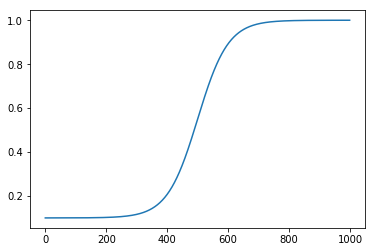

In [6]:
plt.plot(f(np.arange(1000)))

In [34]:
o, u = policy(x_train)
x_pred = policy.dynamics(x_train_, unstandardize_data(u, stats[0][:,:,4:], stats[1][:,:,4:]))

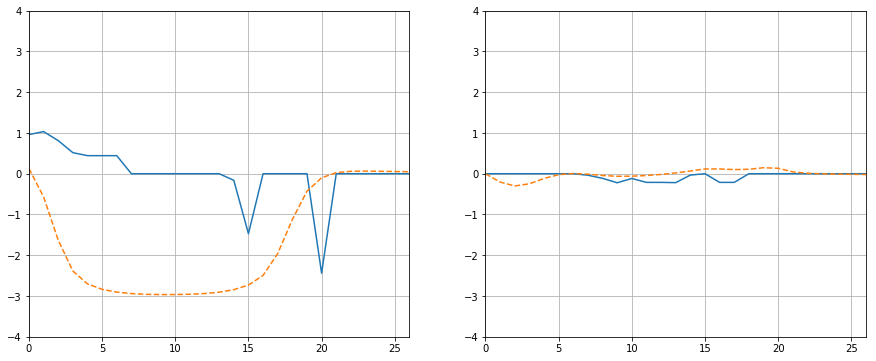

In [35]:
fig = plt.figure(figsize=(15,6))
for k in [0,1]:
    plt.subplot(1,2,k+1)
    plt.plot(u_eval_.squeeze().detach().numpy()[:,k])
    plt.plot(unstandardize_data(u, stats[0][:,:,4:], stats[1][:,:,4:]).squeeze().detach().numpy()[:,k],'--')
    plt.grid()
    plt.xlim([0, 26])
    plt.ylim([-4,4])


In [36]:
unstandardize_data(u, stats[0][:,:,4:], stats[1][:,:,4:]).squeeze().detach().numpy()

array([[ 1.27316102e-01, -1.92650035e-03],
       [-5.66868186e-01, -2.04524219e-01],
       [-1.62754881e+00, -3.00688088e-01],
       [-2.38594484e+00, -2.47054845e-01],
       [-2.70197558e+00, -1.16027951e-01],
       [-2.83608532e+00, -2.40933299e-02],
       [-2.90418625e+00,  5.68884239e-03],
       [-2.94026113e+00, -9.86204296e-03],
       [-2.95784235e+00, -4.36282493e-02],
       [-2.96434927e+00, -6.20682985e-02],
       [-2.96349478e+00, -6.05247431e-02],
       [-2.95610499e+00, -4.48027961e-02],
       [-2.93918753e+00, -1.69506706e-02],
       [-2.90617514e+00,  1.88230909e-02],
       [-2.84416509e+00,  6.57760203e-02],
       [-2.73177958e+00,  1.17327407e-01],
       [-2.49438000e+00,  1.16793111e-01],
       [-1.95758295e+00,  1.00992322e-01],
       [-1.12409794e+00,  1.09310016e-01],
       [-4.28921342e-01,  1.46627456e-01],
       [-9.92295593e-02,  1.33874506e-01],
       [ 2.57252529e-02,  4.53897901e-02],
       [ 6.00408167e-02,  1.15580261e-02],
       [ 6.

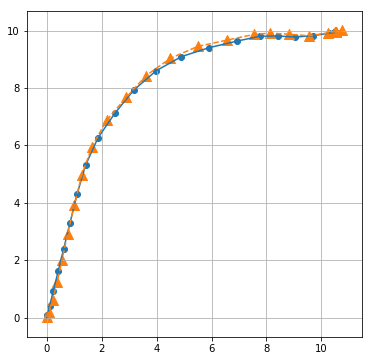

In [37]:
fig = plt.figure(figsize=(6,6))
plt.plot(x_train_.squeeze().detach().numpy()[:,0], x_train_.squeeze().detach().numpy()[:,1])
plt.plot(x_pred.squeeze().detach().numpy()[:,0], x_pred.squeeze().detach().numpy()[:,1],'--')
plt.scatter(x_train_.squeeze().detach().numpy()[:,0], x_train_.squeeze().detach().numpy()[:,1])
plt.scatter(x_pred.squeeze().detach().numpy()[:,0], x_pred.squeeze().detach().numpy()[:,1], marker='^', s=100)
plt.grid()



In [38]:
x_future, u_future = policy.propagate_n(T, x_train[:1,:,:])
complete_traj = policy.join_partial_future_signal(x_train[:1,:,:], x_future)

In [39]:
p = unstandardize_data(complete_traj, stats[0][:,:,:4], stats[1][:,:,:4]).detach()

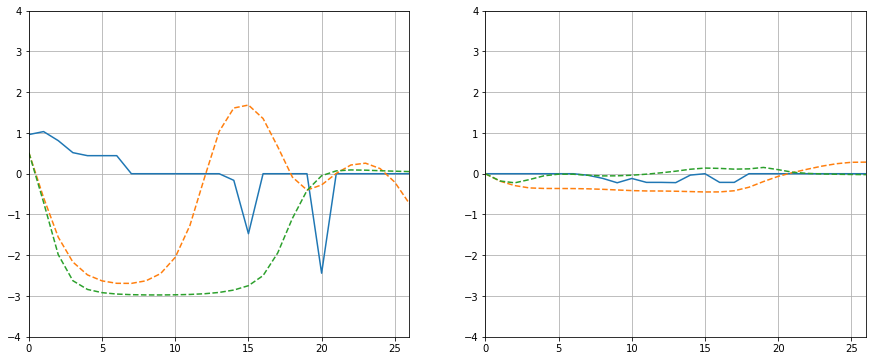

In [40]:
x_future, u_prop = policy.propagate_n(T, x_eval[:1,:,:])
o, u = policy(x_eval)
fig = plt.figure(figsize=(15,6))
for k in [0,1]:
    plt.subplot(1,2,k+1)
    plt.plot(u_eval_.squeeze().detach().numpy()[:,k])
    plt.plot(unstandardize_data(u_prop, stats[0][:,:,4:], stats[1][:,:,4:]).squeeze().detach().numpy()[:,k],'--')
    plt.plot(unstandardize_data(u, stats[0][:,:,4:], stats[1][:,:,4:]).squeeze().detach().numpy()[:,k],'--')

    plt.grid()
    plt.xlim([0, 26])
    plt.ylim([-4,4])


In [45]:
traj_np[:,0,:]

array([[-0.38498068,  0.08230734,  1.9483333 ,  0.82909447],
       [-0.47451687,  0.2535591 ,  1.973582  ,  0.        ],
       [-0.3194313 , -0.04859352,  1.927916  ,  0.        ],
       [-0.16888952, -0.37867832,  1.8785026 ,  0.        ],
       [-0.05049658, -0.72728825,  1.8644512 ,  0.        ],
       [ 0.04130316, -1.0850906 ,  1.8948996 ,  0.        ],
       [ 0.12369108, -1.4443913 ,  1.9651866 ,  0.        ],
       [ 0.21366024, -1.797924  ,  2.0666952 ,  0.        ],
       [ 0.33065414, -2.1275883 ,  2.168962  ,  0.        ],
       [ 0.44507504, -2.3757095 ,  2.2488284 ,  0.        ],
       [ 0.4346304 , -2.3550797 ,  2.2420712 ,  0.09249318],
       [ 0.30718994, -2.0693483 ,  2.150613  ,  1.1593977 ],
       [ 0.09406281, -1.2174101 ,  1.8932748 ,  2.3630838 ],
       [ 0.22832298,  0.20628977,  1.4722879 ,  3.3994412 ],
       [ 1.2060823 ,  1.7259717 ,  0.937887  ,  3.9155102 ],
       [ 2.9130955 ,  2.5528011 ,  0.37626874,  3.771997  ],
       [ 4.67617   ,  2.

In [41]:
def foo(j):
    fig = plt.figure(figsize=(10,10))
    cov_env.draw2D(kwargs=draw_params)
    plt.axis("equal")
#     for j in range(ic_eval.shape[1]):
    plt.plot(traj_np[:,j,0], traj_np[:,j,1])
    plt.scatter(traj_np[:,j,0], traj_np[:,j,1])
    plt.xlim([-3, 12])
    plt.ylim([-3, 12])
    plt.scatter(x_train_.squeeze().numpy()[:,0], x_train_.squeeze().numpy()[:,1])
    plot_xy_from_tensor(p, fig)
    
interact(foo, j=widgets.IntSlider(min=0, max=ic_eval.shape[1]-1, step=1, value=10))

interactive(children=(IntSlider(value=10, description='j', max=127), Output()), _dom_classes=('widget-interact…

<function __main__.foo(j)>

In [142]:
def kinematic_bicycle(x, u, dt=0.5, stats=(torch.zeros([1,1,6]), torch.ones([1,1,6])), lr=0.7, lf=0.5, V_min=0.0, V_max=5.0, a_min=-3, a_max=3, delta_min=-0.344, delta_max=0.344):
    '''
    x is [..., state_dim]
    u is [..., ctrl_dim]

    The kinematic bicycle model with zero-order hold on controls.
    Computed using mathematica
    '''
    μ = stats[0]
    σ = stats[1]
    # unscale
    x, y, psi, V = unstandardize_data(x, μ[:,:,:4], σ[:,:,:4]).split(1, dim=-1)
    a, delta = unstandardize_data(u, μ[:,:,4:], σ[:,:,4:]).split(1, dim=-1)

    beta = torch.atan(lr / (lr + lf) * torch.tan(delta.clamp(delta_min, delta_max)))

    tol = 1E-3
    a = a.clamp(a_min, a_max)

    int_V =  torch.where(a == 0, 
                         V * dt, 
                         torch.where(a > 0, torch.where(((V_max - V) / a) >= dt, 
                                                        0.5 * a * dt**2 * torch.sin(beta) / lr + dt *V * torch.sin(beta) / lr, 
                                                        V * ((V_max - V) / a) + 0.5 * ((V_max - V) / a) * (V_max - V) + (dt - ((V_max - V) / a)) * V_max),
                                            torch.where(((V_min - V) / a) >= dt, 
                                                        0.5 * a * dt**2 * torch.sin(beta) / lr + dt *V * torch.sin(beta) / lr, 
                                                        0.5 * V * ((V_min - V) / a))))

    psi_new = psi + int_V
    V_new = (a*dt + V).clamp(V_min, V_max)
    x_new = x + torch.where(torch.abs(beta) > tol,
                            -lr * torch.sin(beta + psi) / torch.sin(beta) + lr * torch.sin(beta + psi_new) / torch.sin(beta),
                            int_V * torch.cos(psi))
    y_new = y + torch.where(torch.abs(beta) > tol,
                            lr * torch.cos(beta + psi) / torch.sin(beta) - lr * torch.cos(beta + psi_new) / torch.sin(beta),
                            int_V * torch.sin(psi))
    # scale
    return standardize_data(torch.cat([x_new, y_new, psi_new, V_new], dim=-1), μ[:,:,:4], σ[:,:,:4])


In [132]:
torch.where(a == 0, V * dt,
torch.where(a > 0, torch.where(((V_max - V) / a) >= dt, 0.5 * a * dt**2 * torch.sin(beta) / lr + dt *V * torch.sin(beta) / lr, V * tau + 0.5 * tau * (V_max - V) + (dt - tau) * V_max),
                   torch.where(((V_max - V) / a) >= dt, 0.5 * a * dt**2 * torch.sin(beta) / lr + dt *V * torch.sin(beta) / lr, 0.5 * V * tau)))

NameError: name 'a' is not defined

In [134]:
x0 = torch.zeros([1,1,4])
u0 = torch.zeros([1,1,2])
u0[0,0,-1] = 0.5
kinematic_bicycle(x0, u_future[:1,:1,:])

tensor([[[0., 0., 0., 0.]]], grad_fn=<DivBackward0>)

In [135]:
u_future[0,0,:]

tensor([-2.3764,  1.7602], grad_fn=<SliceBackward>)

In [143]:
policy.dynamics = kinematic_bicycle

In [12]:
def propagate_dynamics(dynamics, x0, us, stats=(torch.zeros([1,1,6]), torch.ones([1,1,6]))):
    xs = []
    xs.append(x0)
    for i in range(us.shape[0]):
        xs.append(dynamics(xs[-1], us[i:i+1,:,:], stats=stats))
    return torch.cat(xs, 0)

In [144]:
x_future, u_future = policy.propagate_n(T, ic_eval)
complete_traj = policy.join_partial_future_signal(ic_eval, x_future)

In [145]:
trajs = unstandardize_data(complete_traj, stats[0][:,:,:4], stats[1][:,:,:4]).squeeze().detach().numpy()

In [146]:
us = unstandardize_data(u_future, stats[0][:,:,4:], stats[1][:,:,4:]).squeeze().detach().numpy()

In [147]:
ic_eval[:,0,:]

tensor([[-1.3507, -1.8466,  2.3671, -0.4622]])

In [148]:
kinematic_bicycle(ic_eval[:,:1,:], u_future[:1,:1,:], stats=stats)

tensor([[[-1.5363, -1.5149,  2.7216, -1.4449]]], grad_fn=<DivBackward0>)

In [149]:
def foo(j):
    fig = plt.figure(figsize=(10,10))
    cov_env.draw2D(kwargs=draw_params)
    plt.axis("equal")
#     for j in range(ic_eval.shape[1]):
    plt.plot(trajs[:,j,0], traj_np[:,j,1])
    plt.scatter(trajs[:,j,0], traj_np[:,j,1])
    plt.xlim([-3, 12])
    plt.ylim([-3, 12])
    plt.scatter(x_train_.squeeze().numpy()[:,0], x_train_.squeeze().numpy()[:,1])
    plot_xy_from_tensor(p, fig)
#     plt.xlim([-2, 2])
#     plt.ylim([-2, 2])
    
interact(foo, j=widgets.IntSlider(min=0, max=ic_eval.shape[1]-1, step=1, value=10))

interactive(children=(IntSlider(value=10, description='j', max=127), Output()), _dom_classes=('widget-interact…

<function __main__.foo(j)>

In [ ]:
class ExpertDemoDataset(torch.utils.data.Dataset):

    def __init__(self, npy_file):
        
        # [t, x, y, psi, V]
        self.data = np.load(npy_file)
        self.max_length = self.data.shape[0]


    def __len__(self):
        return data.shape[0]

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        time = self.data[idx, 0]
        state = np.zeros([self.max_length, 4])
        control = np.zeros([self.max_length, 2])
        state[:idx,:] = self.data[:idx, 1:5]
        control[:idx,:] = self.data[:idx, 5:7]
        
        
        return {'state': state, 'control': control, 'time': time, 'idx': idx}
    
    
def prepare_data(npy_file):
    # [t, x, y, psi, V, a, delta]
    data = np.load(npy_file)[:,1:]
    μ = np.mean(data, axis=0, keepdims=True)
    σ = np.std(data, axis=0, keepdims=True)
    x = torch.tensor(data[:, :4]).float().unsqueeze(1).requires_grad_(False)
    u = torch.tensor(data[:, 4:6]).float().unsqueeze(1).requires_grad_(False)
    return x, u, (torch.tensor(μ).float().unsqueeze(1).requires_grad_(False), torch.tensor(σ).float().unsqueeze(1).requires_grad_(False),)


def kinematic_bicycle(x, u, dt=0.5, stats=(torch.zeros([1,1,6]), torch.ones([1,1,2])), lr=0.7, lf=0.5, V_min=0.0, V_max=5.0, a_min=-3, a_max=3, delta_min=-0.344, delta_max=0.344):
    '''
    x is [..., state_dim]
    u is [..., ctrl_dim]
    '''
    μ = stats[0]
    σ = stats[1]
    # unscale
    x, y, psi, V = (x * σ[:,:,:4] + μ[:,:,:4]).split(1, dim=-1)
    a, delta = (u * σ[:,:,4:] + μ[:,:,4:]).split(1, dim=-1)

    beta = torch.atan(lr / (lr + lf) * torch.tan(delta.clamp(delta_min, delta_max)))
    
    psi_new = psi + 0.5 * a * dt**2 * torch.sin(beta) / lr + dt *V * torch.sin(beta) / lr
    V_new = (a.clamp(a_min, a_max)*dt + V).clamp(V_min, V_max)
    x_new = x - lr * torch.sin(beta + psi) / torch.cos(beta) + lr * torch.sin(beta + psi_new) / torch.cos(beta)
    y_new = y + lr * torch.cos(beta + psi) / torch.cos(beta) - lr * torch.cos(beta + psi_new) / torch.cos(beta)
    # scale
    return (torch.cat([x_new, y_new, psi_new, V_new], dim=-1) - μ[:,:,:4]) / σ[:,:,:4]


def initial_conditions(n):
    good_samples = np.zeros([1,2*n,4])
    total = 0
    while total < n:
        x0 = np.random.rand(1,n,4)
        x0[:,:,:2] -= 0.5
        x0[:,:,:2] *= 2.0
        x0[:,:,2] *= np.pi/4 + 3 * np.pi/4
        x0[:,:,3] *= 2
        p = torch.tensor(x0).float()
        v = vf(p).squeeze().numpy() < 0
        num_new = np.sum(v)
        good_samples[:,total:num_new+total,:] = x0[:,v,:]
        total += num_new
    return good_samples[:,:n,:]


class InitialConditionDataset(torch.utils.data.Dataset):

    def __init__(self, n):
        self.n = n
        self.ic = initial_conditions(n)


    def __len__(self):
        return self.n

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        return self.ic[:,idx,:]
    
def standardize_data(x, mu, sigma):
    return (x - mu)/sigma

def unstandardize_data(x, mu, sigma):
    return x * sigma + mu



    
class STLPolicy(torch.nn.Module):

    def __init__(self, dynamics, state_dim, ctrl_dim, hidden_dim, stats, num_layers=1, dt = 0.5, a_min=-3, a_max=3, delta_min=-0.344, delta_max=0.344):
        super(STLPolicy, self).__init__()
        
        self.dynamics = dynamics
        self.stats = stats
        self.dt = dt      
        self.state_dim = state_dim

        a_lim_ = torch.tensor([a_min, a_max]).float().unsqueeze(0).unsqueeze(0)
        delta_lim_ = torch.tensor([delta_min, delta_max]).float().unsqueeze(0).unsqueeze(0)
        self.a_lim = standardize_data(a_lim_, stats[0][:,:,4:5], stats[1][:,:,4:5])
        self.delta_lim = standardize_data(delta_lim_, stats[0][:,:,5:], stats[1][:,:,5:])
        
        self.lstm = torch.nn.LSTM(state_dim, hidden_dim, num_layers)
        self.proj = torch.nn.Sequential(torch.nn.Linear(hidden_dim, ctrl_dim), torch.nn.Tanh())
        self.initialize_rnn = [torch.nn.Linear(state_dim, hidden_dim),  torch.nn.Linear(state_dim, hidden_dim)]
        self.L2loss = torch.nn.MSELoss()
        

    def switch_device(self, device):
        self.a_lim.to(device)
        self.delta_lim.to(device)
        self.stats[0].to(device)
        self.stats[1].to(device)

    def initial_rnn_state(self, x0):
        # x0 is [bs, state_dim]
        return [l(x0) for l in self.initialize_rnn]
    
    def forward(self, x):        
        # x is [time_dim, bs, state_dim]
        h0 = self.initial_rnn_state(x[:1,:,:])

        o, _ = self.lstm(x, h0)    # [time_dim, bs, hidden_dim] , bs = 1 for a single expert trajectory.
        
        # [time_dim, bs, ctrl_dim]  projecting between u_min and u_max (standardize) since proj is between -1 and 1 due to tanh
        u = (self.a_lim[:,:,1:] - self.a_lim[:,:,:1]) / 2 * self.proj(o) + self.a_lim.mean(-1, keepdims=True)
        return o, u
            
    
    def propagate_n(self, n, x_partial):
        '''
        n is the number of time steps to propagate forward
        x_partial is the input trajectory [time_dim, bs, state_dim]
        dynamics is a function that takes in x and u and gives the next state
        '''
        h0 = self.initial_rnn_state(x_partial[:1,:,:])

        x_future = []
        u_future = []
        
        o, h = self.lstm(x_partial, h0)    # h is the last hidden state/last output

        x_prev = x_partial[-1:, :,:]    # [1, bs, state_dim]

        for i in range(n):
            u_ = self.proj(h[0])    # [1, bs, ctrl_dim]
            u = (self.a_lim[:,:,1:] - self.a_lim[:,:,:1]) / 2 * u_ + self.a_lim.mean(-1, keepdims=True)
            u_future.append(u)
            x_next = self.dynamics(x_prev, u, stats=self.stats)    # [1, bs, state_dim]
            x_future.append(x_next)
            o, h = self.lstm(x_next, h)    # o, (h,c) are [1, bs, hidden_dim]

            x_prev = x_next
                
        return torch.cat(x_future, 0), torch.cat(u_future, 0)    # [n, bs, state_dim/ctrl_dim]
        
        
    def control_loss(self, x_partial, u_true):
        '''
        Encourage the policy to imitate the controls from the expert demonstration
        '''
        o, u = self.forward(x_partial)
        return self.L2loss(u, u_true)
    @staticmethod
    def join_partial_future_signal( x_partial, x_future):
        return torch.cat([x_partial, x_future], 0)
    
    def STL_loss_n(self, n, x_partial, formula, formula_input_func, **kwargs):
        '''
        Given partial trajectory, roll out the policy to get a complete trajectory.
        Encourage the complete trajectory to satisfy an stl formula
        '''
        x_future, u_future = self.propagate_n(n, x_partial)    # [n, bs, state_dim/ctrl_dim]
        x_complete = self.join_partial_future_signal(x_partial, x_future)
        signal = unstandardize_data(x_complete, self.stats[0][:,:,:self.state_dim], self.stats[1][:,:,:self.state_dim]).permute([1,0,2]).flip(1)    # [bs, time_dim, state_dim]
        return torch.relu(-formula.robustness(formula_input_func(signal), **kwargs)).mean()
    
    def STL_loss(self, x, formula, formula_input_func, **kwargs):
        signal = unstandardize_data(x, self.stats[0][:,:,:self.state_dim], self.stats[1][:,:,:self.state_dim]).permute([1,0,2]).flip(1)    # [bs, time_dim, state_dim]

        return torch.relu(-formula.robustness(formula_input_func(signal), **kwargs)).mean()
    
    def HJI_loss(self, x_traj):
        '''
        x is [time_dim, bs, state_dim]
        Given a trajectory, compute the integral (finite differencing) of the value function along the trajectory
        Want the value to be negative (more negative the better)
        '''
        
        total_value = vf(unstandardize_data(x_traj, self.stats[0][:,:,:self.state_dim], self.stats[1][:,:,:self.state_dim])).squeeze(-1).sum(0) * self.dt    # [time_dim, bs, 1]

        return torch.relu(total_value).mean()

In [ ]:
class HJIValueFunction(torch.autograd.Function):
        
    @staticmethod
    def forward(ctx, input):
        """
        [bs, x_dim]
        In the forward pass we receive a Tensor containing the input and return
        a Tensor containing the output. ctx is a context object that can be used
        to stash information for backward computation. You can cache arbitrary
        objects for use in the backward pass using the ctx.save_for_backward method.
        """
        ctx.save_for_backward(input)
        return value_interp(input.split(1, dim=-1))

    @staticmethod
    def backward(ctx, grad_output):
        """
        In the backward pass we receive a Tensor containing the gradient of the loss
        with respect to the output, and we need to compute the gradient of the loss
        with respect to the input.
        """
        input, = ctx.saved_tensors
        points = input.split(1, dim=-1)
        gr = torch.zeros_like(input)
        dim = input.shape[-1]
#         IPython.embed(banner1="poop")

        return  torch.cat([deriv_interp[i](points) for i in range(dim)], -1) * grad_output
    
vf = HJIValueFunction.apply
